# Failure Data Analysis Pipeline

## Import Required Libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline
sns.set()

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Data Loading

In [80]:
# Load the dataset
data = pd.read_csv('failure.csv')

# Display initial information
print("Dataset Shape:", data.shape)
data.info()

Dataset Shape: (10081, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            10081 non-null  object 
 1   Model             10081 non-null  object 
 2   Color             10081 non-null  object 
 3   Temperature       10081 non-null  object 
 4   RPM               10081 non-null  int64  
 5   Factory           10081 non-null  object 
 6   Usage             10081 non-null  object 
 7   Fuel consumption  10081 non-null  float64
 8   Membership        7963 non-null   object 
 9   Failure A         10081 non-null  int64  
 10  Failure B         10081 non-null  int64  
 11  Failure C         10081 non-null  int64  
 12  Failure D         10081 non-null  int64  
 13  Failure E         10081 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


## Data Cleaning

In [ ]:
def fahrenheit_to_celsius(temp):

    if "°F" in str(temp):
        value = float(temp.replace(" °F", ""))
        return (value - 32) * 5.0 / 9.0
    elif "°C" in str(temp):
        return float(temp.replace(" °C", ""))
    else:
        return np.nan

# Clean temperature column
data['Temperature'] = data['Temperature'].apply(fahrenheit_to_celsius)

# Handle missing values
categorical_columns = ['Membership', 'Factory', 'Usage']
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Display cleaned data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            10081 non-null  object 
 1   Model             10081 non-null  object 
 2   Color             10081 non-null  object 
 3   Temperature       10081 non-null  float64
 4   RPM               10081 non-null  int64  
 5   Factory           10081 non-null  object 
 6   Usage             10081 non-null  object 
 7   Fuel consumption  10081 non-null  float64
 8   Membership        10081 non-null  object 
 9   Failure A         10081 non-null  int64  
 10  Failure B         10081 non-null  int64  
 11  Failure C         10081 non-null  int64  
 12  Failure D         10081 non-null  int64  
 13  Failure E         10081 non-null  int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 1.1+ MB


## Feature Engineering

In [82]:
# Combine failure columns into a single target column
data['Failure'] = (data[['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']].sum(axis=1) > 0).astype(int)

# One-hot encoding for categorical variables
categorical_columns = ['Model', 'Factory', 'Usage', 'Membership']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Prepare features and target
X = data_encoded.drop(columns=['Failure A', 'Color', 'Failure B', 'Failure C', 'Failure D', 'Failure E', 'Car ID', 'Failure'])
y = data_encoded['Failure']  # Binary failure target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print shapes
print("Training data shape:", X_train_scaled.shape)
print("Testing data shape:", X_test_scaled.shape)

Training data shape: (8064, 51)
Testing data shape: (2017, 51)


## Data Visualization

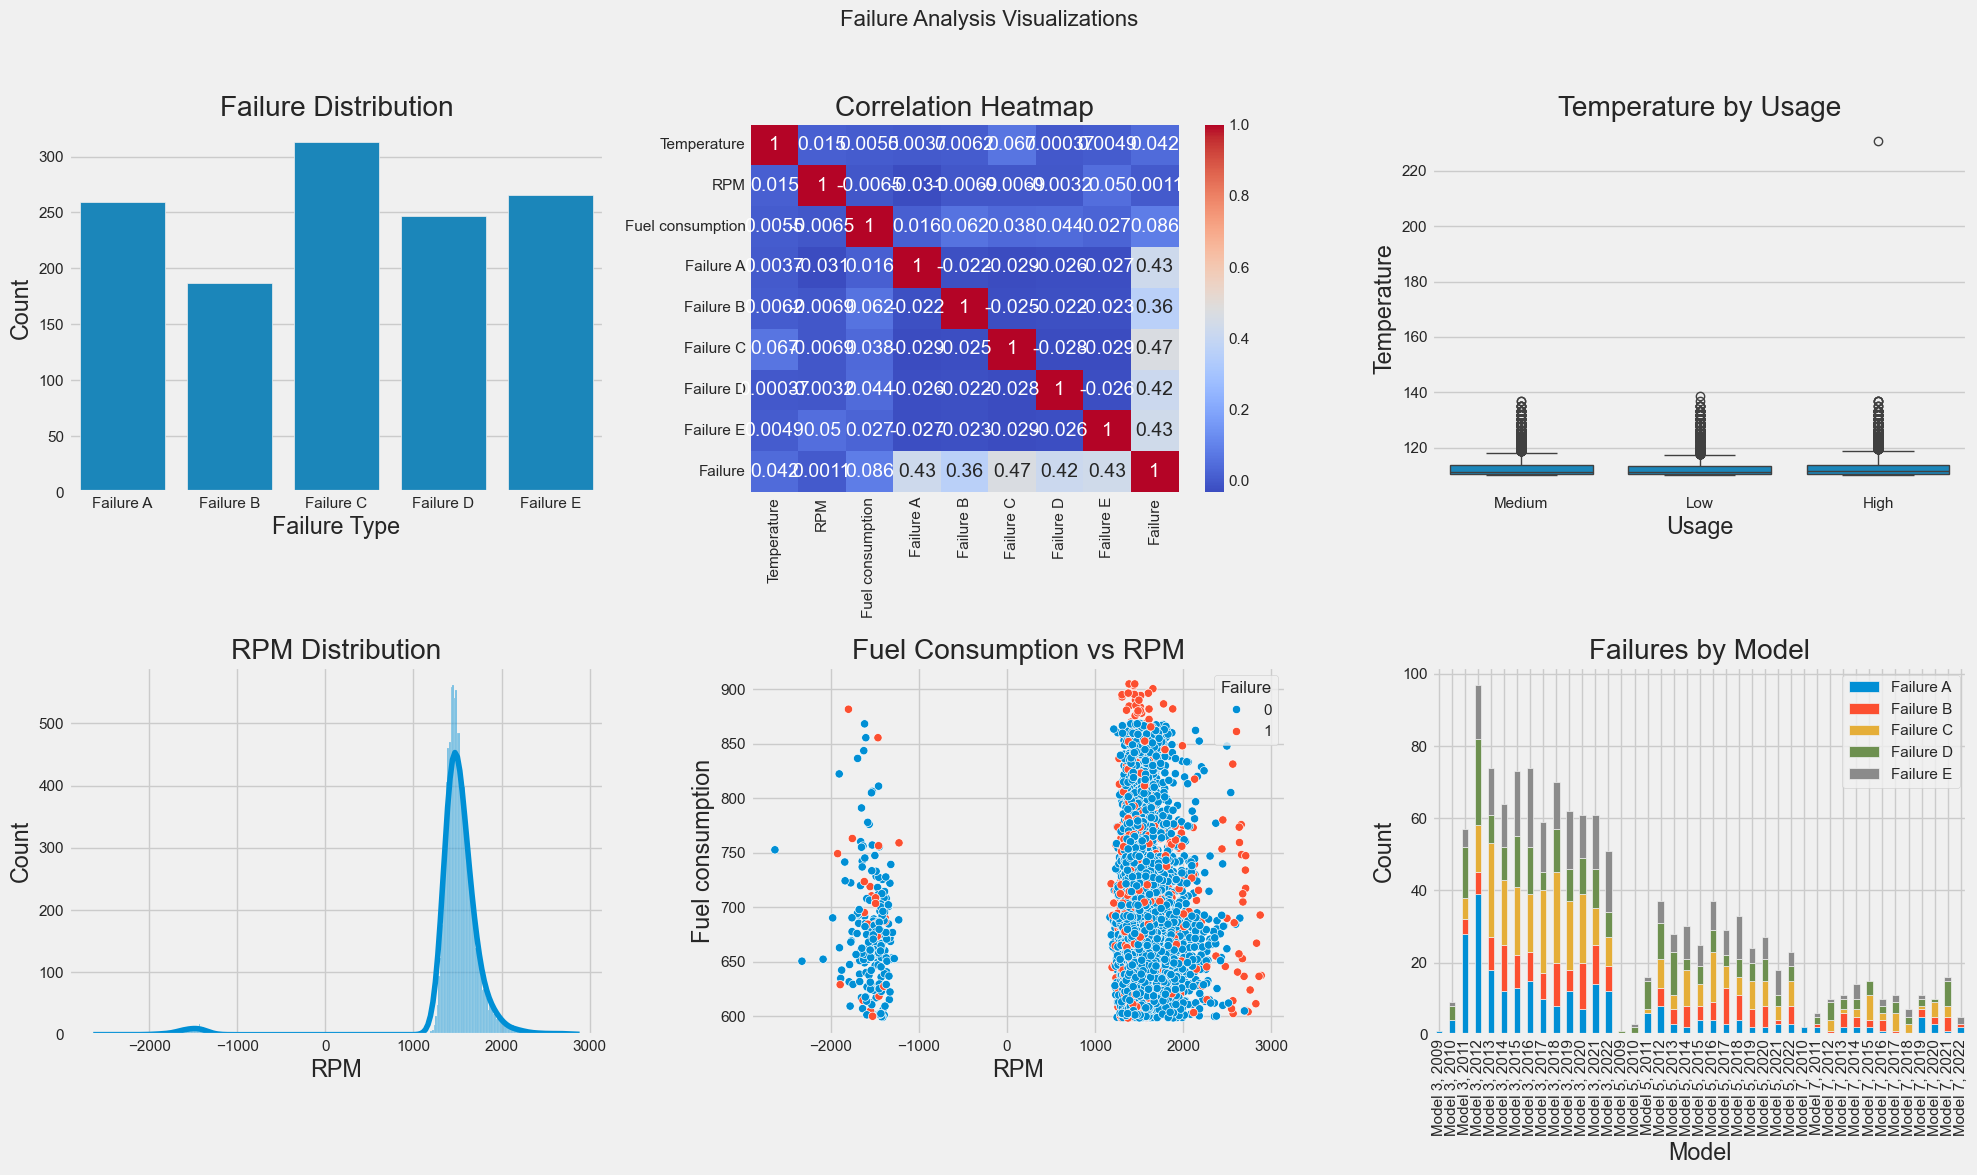

In [83]:
# Set plot style
plt.style.use('fivethirtyeight')

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Failure Analysis Visualizations', fontsize=16)

# 1. Failure Distribution
failure_columns = ['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']
failure_counts = data[failure_columns].sum()
sns.barplot(x=failure_counts.index, y=failure_counts.values, ax=axes[0, 0])
axes[0, 0].set_title('Failure Distribution')
axes[0, 0].set_xlabel('Failure Type')
axes[0, 0].set_ylabel('Count')

# 2. Correlation Heatmap
numeric_cols = data.select_dtypes(include=[np.number]).columns
correlation = data[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Correlation Heatmap')

# 3. Temperature by Usage
sns.boxplot(x='Usage', y='Temperature', data=data, ax=axes[0, 2])
axes[0, 2].set_title('Temperature by Usage')

# 4. RPM Distribution
sns.histplot(data['RPM'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('RPM Distribution')

# 5. Fuel Consumption Scatter
sns.scatterplot(x='RPM', y='Fuel consumption', hue='Failure', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Fuel Consumption vs RPM')

# 6. Model-wise Failure Analysis
failure_by_model = data.groupby('Model')[failure_columns].sum()
failure_by_model.plot(kind='bar', stacked=True, ax=axes[1, 2])
axes[1, 2].set_title('Failures by Model')
axes[1, 2].set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Build and Train the Model

In [84]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Checkpoint to save best model
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/50
161/202 [======================>.......] - ETA: 0s - loss: 0.4288 - accuracy: 0.8634
Epoch 1: val_loss improved from inf to 0.35307, saving model to best_model.keras
202/202 [==============================] - 1s 2ms/step - loss: 0.4217 - accuracy: 0.8658 - val_loss: 0.3531 - val_accuracy: 0.8828
Epoch 2/50
168/202 [=======================>......] - ETA: 0s - loss: 0.3701 - accuracy: 0.8824
Epoch 2: val_loss improved from 0.35307 to 0.34047, saving model to best_model.keras
202/202 [==============================] - 0s 2ms/step - loss: 0.3692 - accuracy: 0.8828 - val_loss: 0.3405 - val_accuracy: 0.8859
Epoch 3/50
169/202 [========================>.....] - ETA: 0s - loss: 0.3439 - accuracy: 0.8855
Epoch 3: val_loss improved from 0.34047 to 0.33956, saving model to best_model.keras
202/202 [==============================] - 0s 2ms/step - loss: 0.3434 - accuracy: 0.8859 - val_loss: 0.3396 - val_accuracy: 0.8859
Epoch 4/50
196/202 [============================>.] - ETA: 0s - loss

## Evaluate the Model

In [85]:
# Load the best weights
model.load_weights('best_model.keras')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.91


In [ ]:
def test_model_usage(input_data):

    # Convert the input data to a DataFrame for consistency with the training data
    input_df = pd.DataFrame([input_data])

    # One-hot encode categorical columns (same as done during training)
    categorical_columns = ['Model', 'Factory', 'Usage', 'Membership']
    input_df_encoded = pd.get_dummies(input_df, columns=categorical_columns, drop_first=True)

    # Ensure the input data has the same columns as the training data
    input_df_encoded = input_df_encoded.reindex(columns=X_train.columns, fill_value=0)

    # Scale the input data (same as done during training)
    input_scaled = scaler.transform(input_df_encoded)

    # Make a prediction using the trained model
    prediction = model.predict(input_scaled)

    # Output the prediction
    return "Failure" if prediction[0] > 0.5 else "No Failure"

In [135]:

# Example usage:
new_data = {
    'Model': 'Model 3, 2022',          # Example model
    'Factory': 'Shang Hai, China',      # Example factory
    'Usage': 'Medium',             # Example usage
    'Membership': 'Premium',        # Example membership
    'Temperature': 110.4,           # Temperature in Celsius
    'RPM': 1408,                 # Example RPM
    'Fuel consumption': 705.3    # Example fuel consumption
}

# Call the function with new data to test the model
result = test_model_usage(new_data)
print(f"Prediction for new data: {result}")


1/1 [==============================] - 0s 13ms/step
Prediction for new data: Failure
